In [7]:
import pandas as pd
import requests
import json
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
API_KEY = "7667fbec8ca714dc11a7bca4b843976c"
SPORT = "americanfootball_nfl"

## Current Odds Data

In [9]:
# API endpoint
url = f"https://api.the-odds-api.com/v4/sports/{SPORT}/odds"
# cost = [number of markets specified] x [number of regions specified]

# Query parameters
params = {
    "apiKey": API_KEY,
    "regions": "us",             # markets: us, uk, eu, au
    "markets": "spreads,totals,h2h", # options: h2h, spreads, totals, outrights
    "oddsFormat": "american",    # american, decimal, fractional
    "dateFormat": "iso"          # iso or unix
}

# Make the request
response = requests.get(url, params=params)

if response.status_code == 200:
    data = response.json()
    print(f"✅ Retrieved {len(data)} games")
else:
    print("Error:", response.status_code, response.text)

✅ Retrieved 30 games


In [10]:
# Save current data json
with open('../data/current_odds.json', 'w') as f:
    json.dump(data, f, indent=4)

In [11]:
# Normalize the layered json data
# df and df2 just provide context to look at what you want to keep from the data

# Expand out the first layer in the bookmaker data, and keep wanted columns
df = pd.json_normalize(
    data,
    record_path=['bookmakers'],
    meta=['id','home_team','away_team','commence_time']
)

# Expand out the second layer
df2 = pd.json_normalize(
    data,
    record_path=['bookmakers','markets'],
    meta=[
        'id',
        'home_team',
        'away_team',
        'commence_time',
        ['bookmakers','key'],
        ['bookmakers','last_update']
    ]
)

# Expand out the third and final layer
df3 = pd.json_normalize(
    data,
    record_path=['bookmakers','markets','outcomes'],
    meta=[
        'id',
        'home_team',
        'away_team',
        'commence_time',
        ['bookmakers','key'],
        ['bookmakers','outcomes','key'],
        ['bookmakers','outcomes','last_update']
    ]
)

# Rename Columns
df3.columns.values[[7,8,9]]=['bookmaker','market','last_update']

# Filter for just draft kings data
df3 = df3[df3['bookmaker']=='draftkings']

pivot = df3.pivot_table(
    index=['id','home_team','away_team','last_update','name','commence_time'],
    columns=['market'],
    values=['price','point']
).reset_index()

pivot.columns = pivot.columns = [''.join(col) for col in pivot.columns]

# extract home, away, point total data
home_data = pivot[pivot.name==pivot.home_team].sort_values(by=['commence_time','home_team'], ascending=[True, True])
away_data = pivot[pivot.name==pivot.away_team].sort_values(by=['commence_time','away_team'], ascending=[True, True])
over_data = pivot[pivot.name=='Over'].sort_values(by=['commence_time','away_team'], ascending=[True, True])
under_data = pivot[pivot.name=='Under'].sort_values(by=['commence_time','away_team'], ascending=[True, True])

# Create base dataframe to merge back
base_df = pivot.groupby(['id','home_team','away_team','last_update','commence_time']).count().reset_index()[['id','home_team','away_team','last_update','commence_time']]

# select desired columns and change names for each subset
home_data = home_data.drop(columns=['home_team','away_team','last_update','name','commence_time','pointtotals','pricetotals'])
home_data = home_data.rename(columns={'pointspreads': 'home_spread','pricespreads':'home_spread_price','priceh2h':'home_ml_price'})

away_data = away_data.drop(columns=['home_team','away_team','last_update','name','commence_time','pointtotals','pricetotals'])
away_data = away_data.rename(columns={'pointspreads': 'away_spread','pricespreads':'away_spread_price','priceh2h':'away_ml_price'})

over_data = over_data.drop(columns=['home_team','away_team','last_update','name','commence_time','pointspreads','priceh2h','pricespreads'])
over_data = over_data.rename(columns={'pointtotals': 'point_total','pricetotals':'over_price'})

under_data = under_data.drop(columns=['home_team','away_team','last_update','name','commence_time','pointspreads','priceh2h','pricespreads','pointtotals'])
under_data = under_data.rename(columns={'pricetotals':'under_price'})

# Merge all dataframes together
current_odds_df = base_df.merge(home_data,on='id').merge(away_data,on='id').merge(over_data,on='id').merge(under_data,on='id')

# Denote if favorite is home
current_odds_df['favorite_home'] = 0
current_odds_df.loc[current_odds_df['home_spread']<0,'favorite_home'] = 1

In [12]:
# Save current odds dataframe with current day date in title
capture_date = pd.to_datetime(current_odds_df.last_update.max()).strftime('%Y-%m-%d')
current_odds_df.to_csv('../data/odds_tracking/' + capture_date + '_odds.csv', index=False)

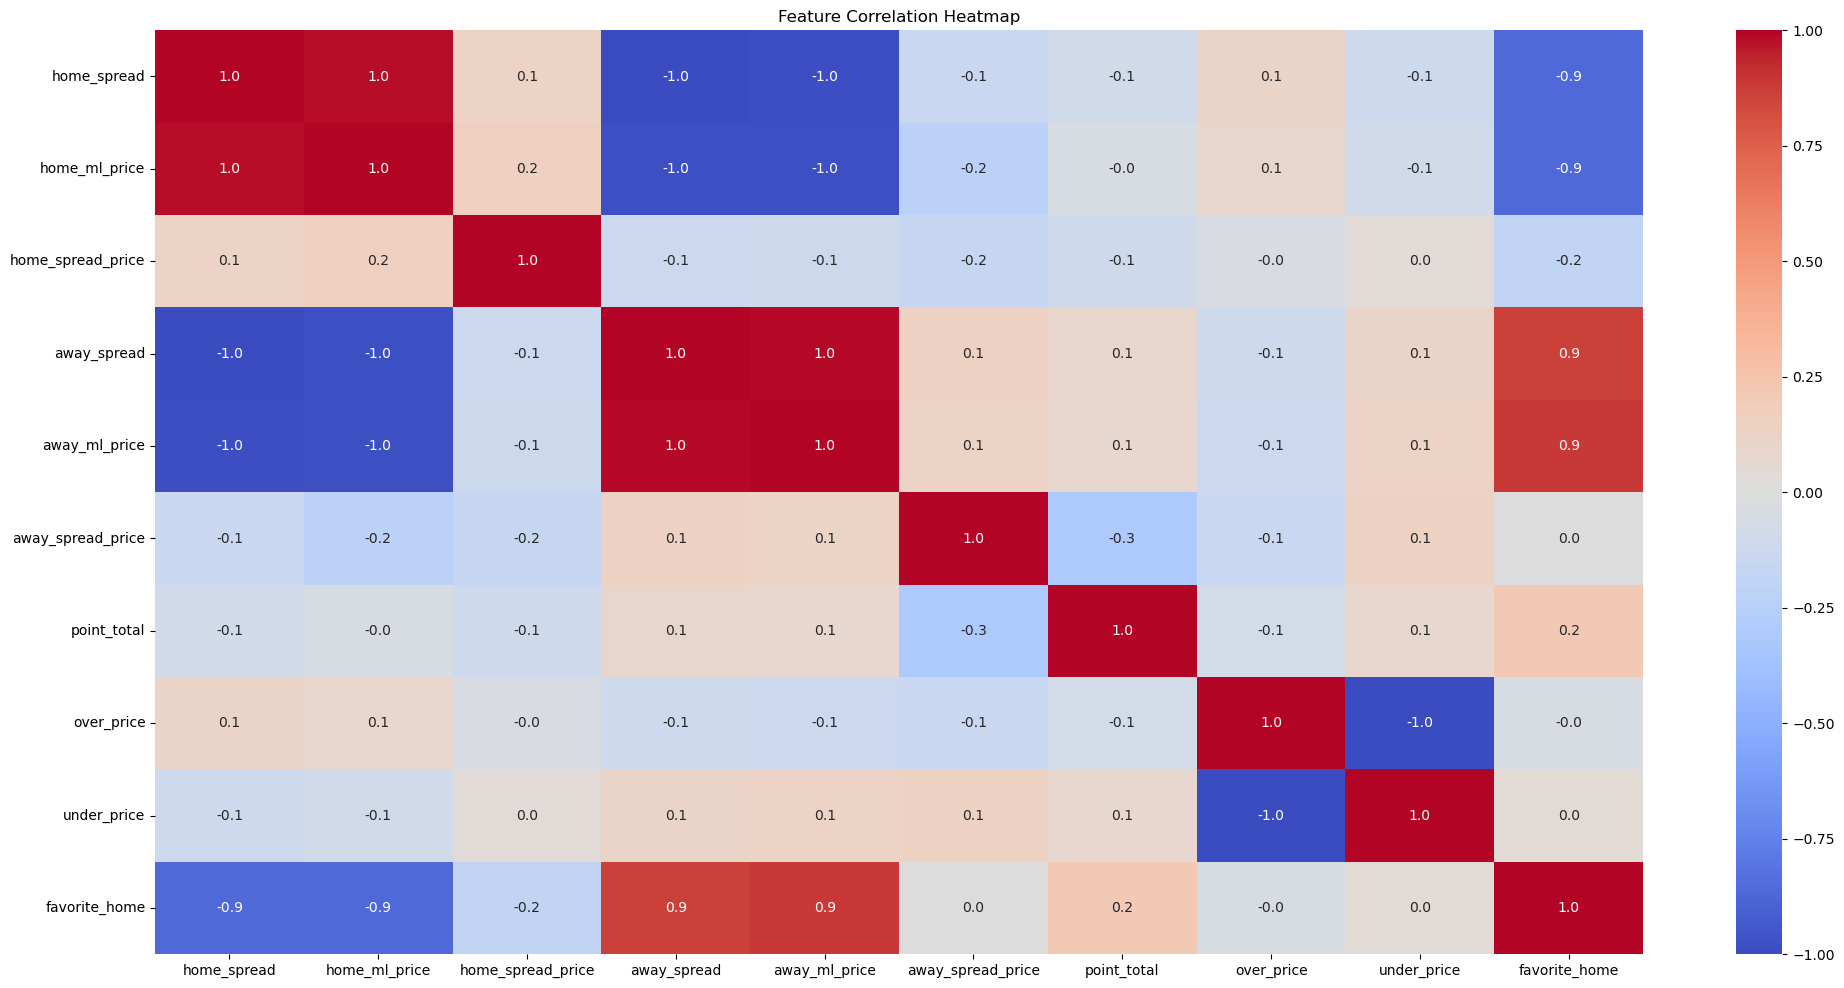

In [205]:
plt.figure(figsize=(24,12))
sns.heatmap(current_odds_df.iloc[:,5:].corr(), annot=True, cmap='coolwarm', fmt=".1f")
plt.title('Feature Correlation Heatmap')
plt.show()

In [201]:
current_odds_df

,id,home_team,away_team,last_update,commence_time,home_spread,home_ml_price,home_spread_price,away_spread,away_ml_price,away_spread_price,point_total,over_price,under_price,favorite_home
0,0ae85bbc3711ad0cb94475a40e2364f0,Atlanta Falcons,Carolina Panthers,2025-11-08T04:10:09Z,2025-11-16T18:00:00Z,-3.5,-180.0,-105.0,3.5,150.0,-115.0,44.5,-110.0,-110.0,1
1,21f47a328fb2ab65c01360a7a2bd9571,Carolina Panthers,New Orleans Saints,2025-11-08T04:10:09Z,2025-11-09T18:00:00Z,-5.5,-245.0,-108.0,5.5,200.0,-112.0,38.5,-108.0,-112.0,1
2,229a5e9ce60dcb344a8cc3c97121154e,Minnesota Vikings,Chicago Bears,2025-11-08T04:10:09Z,2025-11-16T18:00:00Z,-3.0,-162.0,-105.0,3.0,136.0,-115.0,46.5,-115.0,-105.0,1
3,265f0188945bb81ec64751571eb724cb,Miami Dolphins,Washington Commanders,2025-11-08T04:10:09Z,2025-11-16T14:30:00Z,1.5,105.0,-110.0,-1.5,-125.0,-110.0,46.5,-110.0,-110.0,0
4,2710103fe4fb0170ae03b4e34bde8132,San Francisco 49ers,Los Angeles Rams,2025-11-08T04:10:09Z,2025-11-09T21:25:00Z,5.5,190.0,-115.0,-5.5,-230.0,-105.0,49.5,-110.0,-110.0,0
5,32ec2bd4ac9e4c40f9f5cbed7e67f837,New England Patriots,New York Jets,2025-11-08T04:10:09Z,2025-11-14T01:15:00Z,-10.5,-575.0,-115.0,10.5,425.0,-105.0,46.5,-110.0,-110.0,1
6,349d53a4f89591312ea528e81b786474,Los Angeles Chargers,Pittsburgh Steelers,2025-11-08T04:10:09Z,2025-11-10T01:20:00Z,-3.0,-155.0,-105.0,3.0,130.0,-115.0,45.5,-105.0,-115.0,1
7,39e7c1f6e36d5bc4d2613ebf7bb83c10,Tampa Bay Buccaneers,New England Patriots,2025-11-08T04:10:09Z,2025-11-09T18:00:00Z,-2.5,-148.0,-110.0,2.5,124.0,-110.0,48.5,-115.0,-105.0,1
8,3b1a97366685a96e6e1940ae56cc4d31,Chicago Bears,New York Giants,2025-11-08T04:10:09Z,2025-11-09T18:00:00Z,-4.5,-218.0,-110.0,4.5,180.0,-110.0,47.5,-102.0,-118.0,1
9,3c10bc18680995136017c3bfd3152334,Miami Dolphins,Buffalo Bills,2025-11-08T04:10:09Z,2025-11-09T18:00:00Z,9.5,400.0,-108.0,-9.5,-535.0,-112.0,50.5,-105.0,-115.0,0
